In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const .* (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
# function limit_func(param,pmin,pmax)
#     if pmin < param < pmax
#         return param
#     elseif param <= pmin
#         return pmin
#     else
#         return pmax
#     end
# end

function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

function limit_func_abs(param)
    param^2
end

limit_func_abs (generic function with 1 method)

In [4]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
p = [2, 10, 6, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
p[1] = sqrt(p[1])
p[2] = sqrt(p[2])#inv_limit_func(p[2],0,15)
p[3] = sqrt(p[3])
p[4] = inv_limit_func(p[4],0.5,1)

function alpha(p, t)
    Tᵣ = limit_func_abs(p[1])
    Tₐ = limit_func_abs(p[2])
    Tₚ = limit_func_abs(p[3]) + 2*Tᵣ
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tᵣ = limit_func_abs(p[1])
    Tₐ = limit_func_abs(p[2])
    Tₚ = limit_func_abs(p[3]) + 2*Tᵣ
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = limit_func(p[8],0.961pi,1.039pi)
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [5]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3))
ψ0 = ψs[:,1:2]
sizep = length(p);

function f!(du, u, p, t)
    x = u[:,1:2]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling

    du[:,1:2] = -im .* (H * x)
end

function b!(du, u, p, t)
    x = u[:,1:2]
    λ = u[:,3:4]
    ps = u[:,5]

    miH = -im .* (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * λ
    
    du[1:sizep,5] = (- real(im * tr(λ' * chargecoupling * x)) .* dpulsedp(p, t)
                     - real(im * tr(λ' * Potential3 * x)) .* dalphadp(p,t))
end

b! (generic function with 1 method)

In [6]:
function get_T(p)
    Tᵣ = limit_func_abs(p[1])
    Tₐ = limit_func_abs(p[2])
    Tₚ = limit_func_abs(p[3]) + 2*Tᵣ
    2*Tₐ + Tₚ
end
dTdp(p) = ForwardDiff.gradient(p̃ -> get_T(p̃), p)

dTdp (generic function with 1 method)

In [7]:
function wT(L)
    σ = 75e5
    log(L)^4/σ
end

function dwTdL(L)
    σ = 75e5
    4* log(L)^3 /(σ*L)
end

# function f(p)
#     T = get_T(p)

#     forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, T), p)
#     sol = solve(forward_prob, p=p, save_everystep=false, reltol=1e-12, abstol=1e-12)

#     UT = abs2.(ψs[:,1:2]'*sol.u[end])
#     L = 0.5 * (2 - UT[1,2] - UT[2,1])
#     return L + wT(L) * T#L, wT(L) * T
# end

# function b(p)
#     T = get_T(p)

#     forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, T), p)
#     sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

#     xT = sol_f.u[end][:,1:2]

#     UT = abs2.(ψs[:,1:2]'*xT)
#     L = 0.5 * (2 - UT[1,2] - UT[2,1])

#     λ = (1 + dwTdL(L) * T) .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)

#     ps = zeros(289,1) #only 2*length(p) are possibly used
#     bu0 = cat(xT,λ,ps,dims=2)#cat(xT,ψT,λ,ϕ,ps,dims=2);

#     backward_prob = ODEProblem(b!, bu0, (T, 0.0), p)
#     sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)
    
#     grad = real(sol_b.u[end][1:sizep,5])
#     h̃ = -im .* ((KinPot12 + alpha(p, get_T(p)) .* Potential3 + pulse(p,get_T(p)) .* chargecoupling) * xT)

#     grad, - λ'*h̃, L
# end
    # UT = abs2.(ψ0'*xT)
    # infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])

    # loss[1] = infidelity
    # grad[:] = real(sol_b.u[end][1:sizep,5])

dwTdL (generic function with 1 method)

In [12]:
ls = []
params = []

grad = zeros(sizep)
loss = [0.0]
calls  = [1]

function calc(p, last_p, grad, loss)
    if p != last_p
        copy!(last_p, p)

        T = get_T(p)

        forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, T), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        xT = sol_f.u[end][:,1:2]

        UT = abs2.(ψs[:,1:2]'*xT)
        L = 0.5 * (2 - UT[1,2] - UT[2,1])

        λ = (1 + dwTdL(L) * T) .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,λ,ps,dims=2)#cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (T, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)
        
        # grad = real(sol_b.u[end][1:sizep,5])
        h̃ = -im .* ((KinPot12 + alpha(p, get_T(p)) .* Potential3 + pulse(p,get_T(p)) .* chargecoupling) * xT)

        # grad, - λ'*h̃, L
        println(real(tr(- λ'*h̃)),"\t", L,"\t", wT(L)*T,"\t", T)

        loss[1] = L + wT(L) * T
        grad[:] = real(sol_b.u[end][1:sizep,5]) + wT(L) .* dTdp(p)

        push!(ls, copy(loss[1]))
        push!(params, copy(p))

        if sum(calls)%10 == 0
            writedlm("tmp_ls.txt",ls)
            writedlm("tmp_params.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    push!(calls,1)
end

get_grad! (generic function with 1 method)

In [13]:
initial_p = copy(p)
last_p = similar(initial_p);

In [14]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()),Optim.Options(g_tol=1e-4,f_tol=1e-6))

6.821210263296962e-13	2.9359166583364793e-5	0.04744392192652444	30.000000000000004


0.0	0.9992604837548125	1.5006132617336136e-18	37.574796316927504


-2.220446049250313e-15	0.03383359063807362	0.0005393390371856583	30.762441389542584


4.926614671774132e-16	0.9999942742074762	6.736892352060875e-27	47.008183487216


1.3766765505351941e-14	0.6326161823218239	1.914378580537391e-7	32.661730347344744


3.608224830031759e-15	0.00921161963127326	0.0019925379665421974	30.95855813556122


-2.886579864025407e-15	0.008592304141012475	0.0021590616748074424	31.6252874502053


-8.881784197001252e-15	0.0015338817747058142	0.007343156279942585	31.236073567666782


-1.5543122344752192e-15	0.004330922079384236	0.0036359286411018037	31.09213225738944


-7.771561172376096e-16	0.0035115215134827737	0.004230215590584368	31.09607403632292


2.42861286636753e-16	0.0031160636415037968	0.00459616433915673	31.07398198191961


1.0928757898653885e-16	0.00314371882579334	0.0045642307628773835	31.04778863215281


-4.371503159461554e-16	0.0032452967456074178	0.004449263108809437	30.94315453996452


-2.220446049250313e-16	0.003327515579494844	0.004287266186053571	30.342959982840654


-3.164135620181696e-15	0.002439296769815469	0.004893640080962204	28.018755528362654


4.829470157119431e-15	0.01816513449654661	0.0006864969696460317	19.94711809473055


-3.788636071533347e-15	0.0024208591006076308	0.004882965479436709	27.81704282580796


5.773159728050814e-15	0.006636436301655557	0.0021800324314714516	25.845090806706196


-7.632783294297951e-16	0.0024207808901979266	0.004834353709204801	27.53952280057705


8.326672684688674e-17	0.002788821896883842	0.0043480873661548725	27.240763119662425


-1.5543122344752192e-15	0.004085571496948659	0.0032383978581347014	26.536763813440423


-1.4710455076283324e-15	0.0031847015252298716	0.003940783593500535	27.049220003924837


-7.494005416219807e-16	0.003040791636590212	0.00407980047188985	27.120354669241472


-4.440892098500626e-16	0.0035130141306865537	0.0036436524663332774	26.792339443508073


1.6306400674181987e-16	0.003065694667422847	0.004054791488451401	27.10637545232209


4.3021142204224816e-16	0.0030644564938191454	0.004051772220593239	27.078630512131635


5.551115123125783e-16	0.0030404576423466168	0.00405716597803422	26.967848000851454


-3.8163916471489756e-17	0.0027929135051490417	0.004230078306904391	26.527873947436838


-4.440892098500626e-16	0.004587105911913858	0.0027816165199938815	24.818473601076132


7.979727989493313e-17	0.0028912117664563475	0.004095550033500079	26.29750891873052


-5.88418203051333e-15	0.007173118338704154	0.0017546210302920632	22.14349325412861


-1.6653345369377348e-15	0.003255465512829403	0.0037386262354339793	26.057766379919656


8.326672684688674e-17	0.0030073308502872043	0.003973160390776502	26.210729002686936


1.6653345369377348e-16	0.0030003810665306663	0.003963567996127769	26.10581721307968


6.869504964868156e-16	0.0025663342647052056	0.004337207626871388	25.689111708121285


-1.249000902703301e-16	0.0026941601161353246	0.0041948622077374815	25.67260479838925


-1.4432899320127035e-15	0.004184681548102864	0.0029599721384697937	24.68266987284424


2.688821387764051e-17	0.0027532432878171753	0.004115182490700364	25.55773072436086


-3.8163916471489756e-16	0.0030373082670722695	0.0038166602475593	25.351077014759582


-7.979727989493313e-17	0.002878084982802065	0.0039607172738874855	25.35271816418042


-5.828670879282072e-16	0.0028315519860229177	0.003950327629014755	25.006370463169645


1.2212453270876722e-15	0.0014967962194163964	0.0056452993378502524	23.654387837056042


1.5543122344752192e-15	0.0023277020438909335	0.004437293277732429	24.63005033151645


2.0816681711721685e-17	0.0026499837138529436	0.004103698883147293	24.835921284118296


3.3306690738754696e-15	0.001771876964351049	0.005084635554023175	23.666733715617756


-2.7755575615628914e-17	0.0021740595387050865	0.004596196498795372	24.394364345949207


1.5959455978986625e-16	0.002543859570907747	0.004202577998197415	24.745429335219242


-3.0531133177191805e-16	0.002506194639489312	0.004218926098924821	24.59511743341279


-6.938893903907228e-17	0.0029513642232897874	0.003685430775897737	24.00050296783177


6.800116025829084e-15	0.004300547205417393	0.002273582729676616	19.341967384493387


1.734723475976807e-15	0.0028450178181267938	0.003680785058696257	23.375631924349072


-2.4424906541753444e-15	0.002963876432586998	0.0031794843848901512	20.765901466442223


1.27675647831893e-15	0.06157054883413071	9.690681449554243e-5	12.036810959317426


-1.7486012637846216e-15	0.0029668474028224923	0.00317450160868244	20.747637617409374


2.1510571102112408e-15	0.0029876426410220813	0.003147629298085248	20.671056801802738


-1.4016565685892601e-15	0.0027928863301021623	0.003276247854803424	20.54602978912714


3.6914915568786455e-15	0.0044569640480198736	0.0020829460109876175	18.19260624634172


-6.418476861114186e-17	0.0022949051394303144	0.0035591815350802516	19.572046026817425


3.427813588530171e-15	0.004442068552833522	0.0021059127797914815	18.347771304996243


3.3393426912553537e-16	0.0023488600192429487	0.003476739146997154	19.413948497825984


-1.4988010832439613e-15	0.003414997065901315	0.002594165318528776	18.697969280884095


-2.220446049250313e-16	0.0024239841443896015	0.003365543744574321	19.189100923292955


-1.8596235662471372e-15	0.004267909825933891	0.0021386694555889547	18.092832512247874


1.1657341758564144e-15	0.0024723211758251873	0.0033033799470492025	19.08370990464342


3.3029134982598407e-15	0.0032064715350168527	0.002675500152544039	18.451716348306775


-1.249000902703301e-16	0.0024952243706468646	0.0032632749051067634	18.968310298722898


-7.771561172376096e-16	0.002514077649893587	0.0032094250349638644	18.74931429472005


-3.8163916471489756e-17	0.0022592323388846425	0.0034062327431796076	18.539063661833016


-3.469446951953614e-18	0.0020788919923813154	0.003402328577264764	17.540049179105438


7.049916206369744e-15	0.07993634831418162	7.592537230559226e-5	13.975072318664184


1.5720931501039814e-17	0.00216771709842023	0.003303331568699248	17.49909109323308


-2.398081733190338e-14	0.3127368836874167	2.607460105724548e-6	10.711909346615707


2.220446049250313e-16	0.002186381839281659	0.0032832599489972573	17.490342146334616


2.0816681711721685e-17	0.0021609138526065275	0.0032765324774245656	17.321592714124463


2.983724378680108e-16	0.0019776891538198504	0.0033373571149525614	16.660037343432414


-1.4432899320127035e-15	0.015005773756873786	0.0005899644554152436	14.228893591040924


1.9845236565174673e-15	0.002411760365019333	0.002902937229353259	16.496025800101805


9.71445146547012e-17	0.0021417241102062445	0.0031561228228745497	16.58838863374164


4.6629367034256575e-15	0.003643326155116644	0.0020928479831578885	15.792241063638249


2.3592239273284576e-16	0.0022043009786918977	0.0030924309815008257	16.561872194237324


-3.0878077872387166e-16	0.0022073291709663323	0.0030685180909858774	16.448564174169498


-8.326672684688674e-16	0.001790368161493805	0.003437225187001574	16.104060631972757


-7.077671781985373e-16	0.0021390690580998517	0.003101947530493815	16.29049127801891


4.926614671774132e-16	0.0019176205550622272	0.0033023661224509154	16.162682563365678


6.938893903907228e-17	0.0018304693504901381	0.00338281350384833	16.07310161507891


2.1371793224034263e-15	0.002536101067400931	0.0026359625828314788	15.489252392305374


-5.655198531684391e-16	0.0018236551929240452	0.003373181864500628	15.989460570441011


3.400058012914542e-16	0.0019429974191468302	0.0031718477227276986	15.655055343388987


4.180683577104105e-16	0.002072178553509385	0.003034234752009427	15.609685207519224


9.992007221626409e-16	0.002694621707513223	0.0025223375063110273	15.438522449583004


1.3877787807814457e-16	0.0020897334361524855	0.0030165056644799403	15.6035132702366


-2.8449465006019636e-16	0.002089141175348308	0.0030139910681623774	15.587641690995191


5.204170427930421e-17	0.002112358546517812	0.002980294260809779	15.524285329124638


-8.881784197001252e-16	0.0022728324719678006	0.002801147542361544	15.305994169638415


3.885780586188048e-16	0.0020825326100717967	0.002970438039173981	15.330886932491541


6.245004513516506e-16	0.002092438898664173	0.0029418179613889214	15.229944298851374


4.718447854656915e-16	0.002181761334211163	0.0028334627835677256	15.073381423855414


-4.996003610813204e-16	0.0022662789110093895	0.0027403068542429564	14.94516859343278


7.008282842946301e-16	0.002213667381249229	0.002769372861540132	14.872889861775313


5.551115123125783e-17	0.0022794598574130687	0.0026642761390001423	14.585992851570001


1.249000902703301e-16	0.00213554764453483	0.0028145910786539683	14.765546075053965


-9.103828801926284e-15	0.91308467394914	7.272155519565856e-11	7.979202093499892


6.938893903907228e-18	0.00213211458037732	0.0028164711618984236	14.759955489830368


3.469446951953614e-16	0.0021356542641808307	0.002790227517183178	14.638208482530251


7.806255641895632e-18	0.001916365271449283	0.0029801931323069396	14.579775279394717


-2.7408630920433552e-15	0.0023349000425098576	0.002589339901632272	14.401944104016493


-2.498001805406602e-16	0.002000061359429539	0.002887330945045007	14.518154643743296


3.400058012914542e-16	0.002089145933641401	0.0027894938489533587	14.4266170095454


1.6653345369377348e-16	0.002028472353239996	0.0028277859979680946	14.348573116857857


4.440892098500626e-16	0.002374236007949504	0.0025033332119199607	14.078185152972363


2.498001805406602e-16	0.002043338496525382	0.002791086950224769	14.229267454443821


-3.0531133177191805e-16	0.001788012063417277	0.0030146293127184154	14.1123620303721


9.020562075079397e-16	0.0021919682729285572	0.0025424007449288796	13.56628357853056


1.1102230246251565e-15	0.02464607184291817	0.0002901708079732083	11.572721819603425


-1.3877787807814457e-16	0.002196454240472767	0.0025260712691936205	13.497167085891716


-3.219646771412954e-15	0.005972756343385122	0.0011587265397064945	12.640867302737593


-1.6653345369377348e-16	0.002198696262157185	0.002518007669520178	13.463055870354982


2.0816681711721685e-17	0.0018854438940126284	0.0027673605371274896	13.39867715613075


-4.553649124439119e-18	0.0017909700268408102	0.002839109593093355	13.30460178132598


1.1102230246251565e-15	0.004931552451166332	0.0013367288593548739	12.59038899239749


-4.5102810375396984e-17	0.0017707267252392578	0.0028550027589730603	13.283330701118485


2.4980018054066022e-15	0.0025636863176269342	0.002190266983872146	12.963889661420968


1.2836953722228372e-16	0.001726249674311675	0.0028781431732157288	13.178091134854627


-1.1015494072452725e-16	0.001818633385564039	0.002772475465905454	13.119050562765981


-1.2212453270876722e-15	0.003250931283914016	0.0018461465366942877	12.854897361454618


2.498001805406602e-16	0.0018389862400829404	0.00275133826711452	13.111291104940172


-4.996003610813204e-16	0.0018676918180963176	0.0027211830951804484	13.095932568206031


1.5959455978986625e-16	0.0018842428369506004	0.002702800915810391	13.080784706460332


-5.412337245047638e-16	0.0018846147456489382	0.002699381518831928	13.065879697577595


2.7755575615628914e-17	0.0018514738606130732	0.002729262762844163	13.062140643656564


-4.510281037539698e-16	0.0018377397425303754	0.0027411324426410174	13.05703268615467


-5.204170427930421e-17	0.0018218839475483972	0.002755333424546295	13.052706792416483


2.3592239273284576e-16	0.0018309872014211637	0.0027447047534317863	13.043532654688367


-1.0842021724855044e-18	0.0017682859392304517	0.0028050264257945745	13.039450364572001


1.2663481374630692e-16	0.0020034795516854498	0.002585002770413668	13.012275718733093


6.028164079019405e-17	0.0017974668577731001	0.0027747737446171664	13.032931053696142


4.3021142204224816e-16	0.0018321531647843559	0.002738791594671397	13.02069138266356


2.498001805406602e-16	0.001827569949962582	0.002739224987995292	13.00207007145777


-3.122502256758253e-17	0.0018870126350001848	0.0026649628912036533	12.90974475839272


1.6653345369377348e-16	0.0019061501809613524	0.002640917618824105	12.875914776153454


-3.8163916471489756e-16	0.0017973270036995004	0.002745470720015788	12.894661772551135


3.95516952522712e-16	0.0018234500284812216	0.0027141083371361578	12.86442104259429


-1.5265566588595902e-15	0.0019335922326872979	0.0025993799820532722	12.789762555868702


-1.5959455978986625e-16	0.0018888842877747836	0.002641559942158319	12.804467767725367


9.71445146547012e-17	0.0018256308794127318	0.002703496475806827	12.8238411652851


4.163336342344337e-17	0.0018378712805262043	0.0026902520091933962	12.815252701044848


-2.498001805406602e-16	0.0018330832679063214	0.002694697537033583	12.81518814284841


4.3021142204224816e-16	0.0018247901609782513	0.002702923180392863	12.817376346194429


2.7755575615628914e-17	0.0018256313896775067	0.0027020675111865764	12.817065246765699


1.5265566588595902e-16	0.0018250775100122074	0.002702615816271217	12.817198858297466


1.249000902703301e-16	0.0018257983959404367	0.0027018869717006246	12.816952562186913


3.0531133177191805e-16	0.0018266500224092264	0.002701017678379802	12.816619810452067


-3.469446951953614e-16	0.0018286224076679014	0.0026990000237047665	12.815817709120724


-2.636779683484747e-16	0.0018314522825780277	0.0026960769875482436	12.814506487793302


-6.036837696399289e-16	0.001836559947207994	0.002690779596597838	12.811957991382917


-2.671474153004283e-16	0.0018408475226294185	0.002686297100891393	12.809569853066943


-3.677613769070831e-16	0.0018423581664105404	0.0026846245946655833	12.808266613398532


-1.1796119636642288e-16	0.0018405404664317282	0.002686341227273769	12.808423084273706


-1.457167719820518e-16	0.0018367771666654709	0.0026898702685696197	12.808590092700955


6.869504964868156e-16	0.0018316898955669236	0.002694379693234451	12.807493684792133


2.185751579730777e-16	0.0018275503154009387	0.0026969018823485747	12.801090963225448


-2.6020852139652106e-16	0.0018324740180832855	0.0026895268169116874	12.787899251551625


-1.5265566588595902e-16	0.0017931478213363272	0.0027259166649467644	12.783980540103144


-4.961309141293668e-16	0.001836451079199386	0.0026796870080863927	12.758661181660056


1.0408340855860843e-16	0.0018483416011232379	0.0026643869061736326	12.737930123451154


-3.226585665316861e-16	0.0018522870384061196	0.0026566282391764164	12.7180648207123


4.163336342344337e-17	0.001874880711861815	0.0026291761764834372	12.684134951131856


-1.2836953722228372e-16	0.001653501491375109	0.002815760719375589	12.549268492958909


3.1086244689504383e-15	0.018242929993651957	0.0003941022461517516	11.50015213598549


3.608224830031759e-16	0.0016487702458978237	0.002820255628369557	12.546833150889423


-3.122502256758253e-16	0.001587816851468582	0.002877230190693905	12.503674280823407


-5.440092820663267e-15	0.006810377335402629	0.0009907084193991368	11.990738871345384


-3.608224830031759e-16	0.0015823221904535667	0.0028807139248845665	12.491917954634143


-1.1310397063368782e-15	0.0015878192042675376	0.0028700006213228015	12.472267971775633


-2.7478019859472624e-15	0.0033500836192171257	0.0017197108608995072	12.229035010020617


-1.8735013540549517e-16	0.0016154666912434057	0.002834786952210106	12.452103099807369


1.942890293094024e-16	0.0016657853342819662	0.0027767037992162346	12.432569135161692


7.216449660063518e-16	0.002308608455732941	0.0022335068941966	12.330368546828714


-4.85722573273506e-17	0.001733517661384798	0.0027042416756748308	12.414614924165402


-1.0061396160665481e-16	0.0017653007691411648	0.002671966689774516	12.40767217652796


-2.3592239273284576e-15	0.004149187024689749	0.0014615769993993515	12.112288437846036


-9.540979117872439e-17	0.0017741665051272948	0.002662979147271281	12.405102618020386


6.800116025829084e-16	0.0018293018963659868	0.0026032633877754773	12.364140206425247


2.42861286636753e-17	0.0017500739391798081	0.0026745192477731048	12.351869888834573


-4.163336342344337e-17	0.0017613245921112575	0.0026480509800539493	12.279135877334548


-1.8318679906315083e-15	0.0035479585442406147	0.0016078321405574108	11.905829492362852


9.71445146547012e-17	0.001752218668700789	0.0026402499469309598	12.203016948056028


-2.2811613709095013e-16	0.0017579306051594967	0.0026236665529072467	12.151274275580146


1.887379141862766e-15	0.00678542180253483	0.0009575134021955951	11.554927619613334


-1.6393136847980827e-16	0.001761174738134974	0.002619264335677083	12.144999073607918


2.2811613709095013e-16	0.001807026392839417	0.00256936072953403	12.108709914980015


2.2898349882893854e-16	0.0017775846901719738	0.002591020323853426	12.084574327500357


-2.5326962749261384e-16	0.0016397881684740434	0.0027237456464436535	12.076243746733168


1.1171619185290638e-15	0.001969831580681425	0.0024104100334959386	12.002003681115513


-3.642919299551295e-17	0.0017031803697321601	0.002653710454048993	12.048243806554268


-1.6653345369377348e-15	0.0022200394990753436	0.002223623976188806	11.964437797598112


2.7755575615628914e-17	0.0017290105934600342	0.0026266827070159904	12.038826745408922


1.0408340855860843e-16	0.0017581380795101964	0.0025957730418222614	12.022982666880345


6.938893903907228e-17	0.0017504327794518604	0.002600912419375822	12.01347958757658


-2.5673907444456745e-16	0.001733791914630689	0.002614050591435786	12.001760782500797


-5.984795992119984e-17	0.0016620623015200509	0.0026855255026926855	12.007515056362214


1.5092094240998222e-16	0.0016976203894260022	0.0026481832038880364	11.998514618618058


5.759281940243e-16	0.0017678691915529732	0.0025780857252574825	11.982710765728548


0.0	0.001725372491770849	0.002619608356975491	11.99051107299766


3.642919299551295e-17	0.0017283227891735642	0.0026155940295070523	11.985004902545647


4.5102810375396984e-17	0.0017223447663546887	0.0026198116646339335	11.978209466961136


-4.336808689942018e-17	0.0017039119156043725	0.00263706204406292	11.975883891863946


-4.0939474033052647e-16	0.0017345173916127332	0.0026062120020428287	11.968921963665068


-5.898059818321144e-17	0.00171405514048234	0.0026264960080591114	11.972424837274179


-2.0816681711721685e-16	0.0017010005888075663	0.002638914155557362	11.971444289595762


-1.5265566588595902e-16	0.001693500892103128	0.0026462920583658453	11.971695639922451


-2.7755575615628914e-17	0.001701899717345412	0.002637848740047452	11.97057872701126


1.0408340855860843e-16	0.0016901904168329374	0.00264949400464804	11.971490070932635


2.7755575615628914e-17	0.001690280481846551	0.002649386665764017	11.971404821279862


1.5959455978986625e-16	0.0016925751942206135	0.0026470492896267066	11.971017730414626


-7.28583859910259e-17	0.0016921917668982212	0.0026474028240468755	11.970916465399078


-3.8163916471489756e-17	0.0016916614161069377	0.002647853224238884	11.970600991262067


-1.97758476261356e-16	0.0016914756473369597	0.0026479403919180055	11.97017112640372


-5.724587470723463e-17	0.0016904249761020007	0.002648747232936635	11.969156676817787


-1.3010426069826053e-16	0.0016845020590942617	0.002654001804266936	11.966557159223365


-2.6020852139652106e-18	0.001651987026301871	0.002685548513304927	11.962092311827309


-5.828670879282072e-16	0.0019327574833890582	0.0024313968837721767	11.959926800887882


-1.3877787807814457e-17	0.0016728708038425966	0.002664272797287907	11.96087533411722


3.469446951953614e-18	0.0016845429824622893	0.0026516724961894414	11.956236532307344


-7.549516567451064e-15	0.005691719119844174	0.0011323143614315914	11.898399373631204


-1.734723475976807e-16	0.0017345600698898123	0.0026007611119795394	11.94407389197014


3.209238430557093e-17	0.0016926388512201185	0.0026425930793667492	11.95114669147327


-9.020562075079397e-16	0.0018637692585619092	0.0024825159253448665	11.931348034695251


-1.0061396160665481e-16	0.0017058117137938589	0.0026284867354592744	11.945290330609145


-4.163336342344337e-17	0.00172672491447462	0.0026059685432793193	11.933956427823961


-3.8163916471489756e-16	0.0017080498615817952	0.0026218369015368003	11.924879628847497


0.0	0.0017725583617776985	0.002559936854810052	11.918268706146703


1.3877787807814457e-16	0.0016991081182602952	0.0026298483885633414	11.921990109518934


-5.065392549852277e-16	0.0017034579270580608	0.002624350392395326	11.916162975780852


1.214306433183765e-17	0.0016835804145817757	0.002644053909749602	11.917617654565653


2.671474153004283e-16	0.0017196489995754405	0.002608198865722819	11.913380470864444


1.5959455978986625e-16	0.0016951754184681977	0.0026323584495741826	11.91604137007187


1.3530843112619095e-16	0.0016984677997789466	0.0026289754350816586	11.915215654462653


-1.0755285551056204e-16	0.0016956642593665139	0.0026317507566890955	11.915444328687286


-3.469446951953614e-18	0.0016922344025509517	0.0026351310807560422	11.915614775987622


6.245004513516506e-17	0.0016912259342028446	0.002636131716518923	11.915686668902115


2.1163626406917047e-16	0.0016905077114927058	0.0026368470307216716	11.915747523294385


-9.71445146547012e-17	0.0016905307230276057	0.002636820452699229	11.915729066780163


 * Status: success

 * Candidate solution
    Final objective value:     4.327351e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.40e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.08e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.24e-07 ≤ 1.0e-06
    |g(x)|                 = 1.03e-04 ≰ 1.0e-04

 * Work counters
    Seconds run:   2511  (vs limit Inf)
    Iterations:    146
    f(x) calls:    243
    ∇f(x) calls:   243


In [125]:
res

 * Status: success

 * Candidate solution
    Final objective value:     4.327351e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.40e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.08e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.57e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.24e-07 ≤ 1.0e-06
    |g(x)|                 = 1.03e-04 ≰ 1.0e-04

 * Work counters
    Seconds run:   2511  (vs limit Inf)
    Iterations:    146
    f(x) calls:    243
    ∇f(x) calls:   243


In [132]:
# writedlm("ls.txt",ls)
# writedlm("params.txt",params)
# readdlm("params.txt")

In [35]:
p_new = copy(Optim.minimizer(res));
1-0.00169

0.99831

In [43]:
times = LinRange(0,get_T(p_new),2000)

forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, get_T(p_new)), p_new)
sol_f = solve(forward_prob, p=p_new, saveat=times, reltol=1e-8, abstol=1e-8)

retcode: Success
Interpolation: 1st order linear
t: 2000-element Vector{Float64}:
  0.0
  0.005960844955868015
  0.01192168991173603
  0.017882534867604046
  0.02384337982347206
  0.029804224779340076
  0.03576506973520809
  0.04172591469107611
  0.04768675964694412
  0.053647604602812135
  ⋮
 11.868042307133218
 11.874003152089086
 11.879963997044955
 11.885924842000822
 11.891885686956691
 11.897846531912558
 11.903807376868427
 11.909768221824296
 11.915729066780163
u: 2000-element Vector{Matrix{ComplexF64}}:
 [7.458437020914339e-10 + 1.9551902702793405e-19im 7.165380802393358e-10 - 4.465451818806265e-19im; 4.750172604670167e-9 - 2.4109872830822624e-9im 4.545922347254764e-9 + 2.4419982821121935e-9im; … ; 4.750172562092263e-9 + 2.410987280507997e-9im 4.545922304677384e-9 - 2.441998265656064e-9im; 7.458437153439597e-10 + 0.0im 7.16538051171195e-10 + 0.0im]
 [6.656695544441812e-10 + 3.3627393342410934e-10im 6.424591675415885e-10 + 3.1716136301161073e-10im; 5.326356954794185e-9 - 9.7895

In [45]:
occs = zeros(Float64,length(sol_f.t),2,2)

for (i,t) in enumerate(sol_f.t)
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha(p_new,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(tmp_ψs[:,:]'*sol_f.u[i])
end

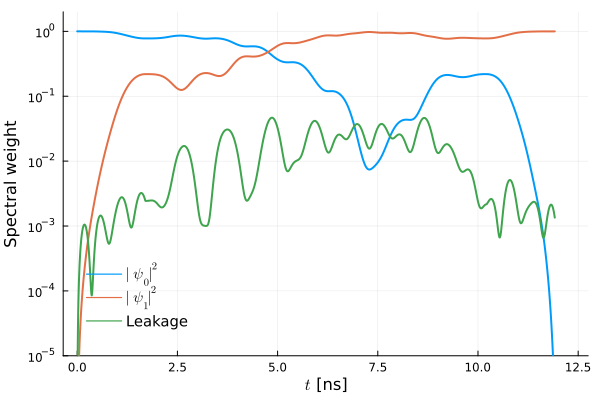

In [76]:
using LaTeXStrings
plt = plot(sol_f.t,
     [occs[:,1,1], occs[:,2,1], abs.(1 .- (occs[:,1,1] + occs[:,2,1]))],
     yaxis=:log10,
     ylim=(1e-5,2),
     linewidth=2,
     yticks=[10^i for i=-5.:0],#(append!([i*10^j for i = 1:9 for j = -5.:-1],[1]),tmp)
     xlabel=L"$t$ [ns]",
     ylabel="Spectral weight",
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" "Leakage"],
     legend=:bottomleft,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     legendfontsize=10,
     xticks=0:2.5:12.5,
     xlim=(-0.35,12.75)
)

In [77]:
# savefig(plt,"FastSwapOccupation.png")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\FastGate\\FastSwapOccupation.png"

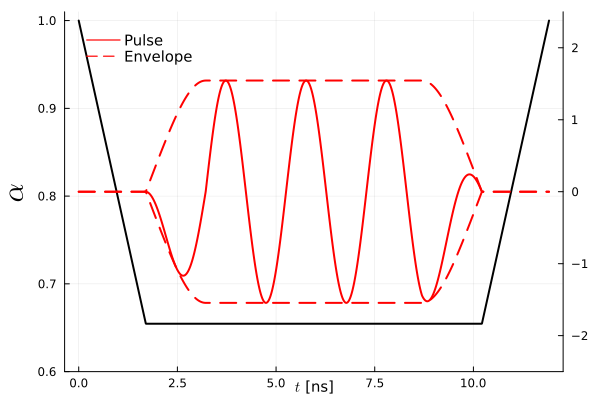

In [123]:
tmp_p = copy(p_new)
tmp_p[6] = 0
# tmp_p[9] = 0
tmp_p[5] = 0

tmp_p2 = copy(p_new)
tmp_p2[6] = 0
# tmp_p2[9] = 0
tmp_p2[5] = pi/2

plt = plot(times,
     [alpha(p_new,t) for t in times],
     ylim=(0.6,1.01),
     linewidth=2,
     color="black",label=nothing,
     labelfontsize=20,ticklabelfontsize=20,
      ylabel=L"$\alpha$")

plot!(twinx(),
      [times[280:1720],times, times],
      [[pulse(p_new,t) for t in times[280:1720]],
       [sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times],
       [-sqrt(pulse(tmp_p,t)^2 + pulse(tmp_p2,t)^2) for t in times]],
      linewidth=2,
      color=[:red :red :red],
      ylim=(-2.5,2.5),
      ls = [:solid :dash :dash],
      label=["Pulse" "Envelope" ""],
      legend=:topleft,
      background_color_legend = nothing,
      foreground_color_legend = nothing,
      legendfontsize=10,
      labelfontsize=10,
      ticklabelfontsize=20,
      xlabel=L"$t$ [ns]")

In [124]:
# savefig(plt,"FastSwapGatePulse.png")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\FastGate\\FastSwapGatePulse.png"

In [82]:
limit_func_abs(p_new[2])/12*2000

283.42792589724627

In [51]:
get_T(p_new), 0.5 * (occs[end,1,2] + occs[end,2,1])

(11.915729066780163, 0.9983094692769721)

In [192]:
real(tr(dLdT))*dTdp(p)

9-element Vector{Float64}:
 3.858659226461246e-12
 8.6282243323741e-12
 3.3416969146626496e-12
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [189]:
dp = zeros(Float64,size(p))
dp[1] = 1e-4
res1 = f(p - dp)
res2 = f(p + dp)

0.04760061503113408

In [190]:
(res2 - res1)/(2*dp[1]), -0.6868060220392537

(-0.6874293750433121, -0.6868060220392537)

In [61]:
(res2 - res1)/(2*dp[1]), 0.0011102195813677887

(0.0011102906094517806, 0.0011102195813677887)

In [63]:
(res2 - res1)/(2*dp[2]), -0.0001487009444301983

(-0.00014696657779644795, -0.0001487009444301983)

In [65]:
(res2 - res1)/(2*dp[3]), 0.001216524164690993

(0.0012170017771317987, 0.001216524164690993)